In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os
import seaborn
from matplotlib.lines import Line2D
from astropy.cosmology import Planck18
plt.rc("font", family="serif")
plt.rc("text", usetex=True)
import warnings
warnings.filterwarnings('ignore')
import astropy.coordinates as coord
import astropy.units as u
import corner
import seaborn as sns

## Read in data

In [2]:
with open('../lensed_SN_catalog/Baselinev3_0_doubles.pkl', 'rb') as f:
    doubles = pickle.load(f)
with open('../lensed_SN_catalog/Baselinev3_0_quads.pkl', 'rb') as f:
    quads = pickle.load(f)
with open('../lensed_SN_catalog/Baselinev3_0_unlensed.pkl', 'rb') as f:
    sne = pickle.load(f)
    
print("Doubles: ", len(doubles))
print("Quads: ", len(quads))
print("Unlensed: ", len(sne))

Doubles:  5000
Quads:  5000
Unlensed:  5000


In [3]:
df_ = pd.read_csv('../lensed_SN_catalog/processed_lcs_ana.csv')
mask_microdet_ = (df_.mult_method_micro==1)|np.isnan(df_.mult_method_micro)|(df_.mag_method_micro==1)|np.isnan(df_.mag_method_micro)

df_out_nim2     = df_[(df_.nima==2.0)]                             # Doubles
df_out_nim4     = df_[(df_.nima==4.0)]                             # Quads
df_out_unlensed = df_[(df_['type']=='unlensed')&(df_.nima==1.0)]   # Unlensed
df_out_lensed   = df_[(df_['type']!='unlensed')]                   # All lenses

mask_microdet = (df_out_lensed.mult_method_micro==1)|(df_out_lensed.mag_method_micro==1)  # Mask for detected with microlensing

plots_path = '../results/figures/'

df_out_nim2.keys()

Index(['g_npoints', 'g_rise_time', 'g_rise_rate', 'g_decay_time',
       'g_decay_rate', 'g_peak_mag', 'g_peak_mag_minus7', 'g_peak_mag_plus7',
       'g_peak_mag_minus14', 'g_peak_mag_plus14',
       ...
       'y_peak_mag_plus14_err_micro_abs_zs',
       'y_peak_mag_plus14_err_micro_abs_zl', 'z_lens', 'ima',
       'mult_method_peak', 'mult_method', 'mult_method_micro',
       'mag_method_peak', 'mag_method', 'mag_method_micro'],
      dtype='object', length=562)

## Compute detected sample

In [5]:
dt_doubles, dt_quads = [], []
mutot_doubles, mutot_quads = [], []
peak_i_doubles, peak_i_quads = [], []
peak_r_doubles, peak_r_quads = [], []
peak_z_doubles, peak_z_quads = [], []
peak_y_doubles, peak_y_quads = [], []

for s in range(len(doubles)):
    
    dt_doubles.append(doubles['time_delay'][s][1])
    dt_quads.append(max(quads['time_delay'][s]))
    mutot_doubles.append(np.sum(doubles['macro_mag'][s]))
    mutot_quads.append(np.sum(quads['macro_mag'][s]))
    peak_r_doubles.append(doubles['peak_magnitudes_micro'][s][1])
    peak_r_quads.append(quads['peak_magnitudes_micro'][s][1])
    peak_i_doubles.append(doubles['peak_magnitudes_micro'][s][2])
    peak_i_quads.append(quads['peak_magnitudes_micro'][s][2])
    peak_z_doubles.append(doubles['peak_magnitudes_micro'][s][3])
    peak_z_quads.append(quads['peak_magnitudes_micro'][s][3])
    peak_y_doubles.append(doubles['peak_magnitudes_micro'][s][4])
    peak_y_quads.append(quads['peak_magnitudes_micro'][s][4])
    
dt_doubles = np.array(dt_doubles)
dt_quads = np.array(dt_quads)
mutot_doubles = np.array(mutot_doubles)
mutot_quads = np.array(mutot_quads)
peak_r_doubles = np.array(peak_r_doubles)
peak_r_quads = np.array(peak_r_quads)
peak_i_doubles = np.array(peak_i_doubles)
peak_i_quads = np.array(peak_i_quads)
peak_z_doubles = np.array(peak_z_doubles)
peak_z_quads = np.array(peak_z_quads)
peak_y_doubles = np.array(peak_y_doubles)
peak_y_quads = np.array(peak_y_quads)

In [6]:
# masks

# Rolling / non-rolling
md_nonrol = (doubles['obs_start']) <= 60768
md_rol = (doubles['obs_start']) > 60768
mq_nonrol = (quads['obs_start']) <= 60768
mq_rol = (quads['obs_start']) > 60768

# Survey
md_WFD = (doubles['survey']) == 'WFD'
md_DDF = (doubles['survey']) == 'DDF'
md_gal = (doubles['survey']) == 'galactic plane'
mq_WFD = (quads['survey']) == 'WFD'
mq_DDF = (quads['survey']) == 'DDF'
mq_gal = (quads['survey']) == 'galactic plane'

# Detected
md_detected = (doubles['mag_method'] == True) | (doubles['mult_method'] == True)
md_detected_micro = (doubles['mag_method_micro'] == True) | (doubles['mult_method_micro'] == True)
md_detected_peak = (doubles['mag_method_peak'] == True) | (doubles['mult_method_peak'] == True)
md_nondetect_micro = (doubles['mag_method_micro'] == False) & (doubles['mult_method_micro'] == False)
md_nondetect = (doubles['mag_method'] == False) & (doubles['mult_method'] == False)
mq_detected_micro = (quads['mag_method_micro'] == True) | (quads['mult_method_micro'] == True)
mq_detected = (quads['mag_method'] == True) | (quads['mult_method'] == True)
mq_nondetect_micro = (quads['mag_method_micro'] == False) & (quads['mult_method_micro'] == False)
mq_nondetect = (quads['mag_method'] == False) & (quads['mult_method'] == False)
mq_detected_peak = (quads['mag_method_peak'] == True) | (quads['mult_method_peak'] == True)

md_detected_micro_mag = (doubles['mag_method_micro'] == True)
md_detected_micro_mult = (doubles['mult_method_micro'] == True)
mq_detected_micro_mag = (quads['mag_method_micro'] == True)
mq_detected_micro_mult = (quads['mult_method_micro'] == True)

md_mult_peak = (doubles['mult_method_peak'] == True)
md_mag_peak = (doubles['mag_method_peak'] == True)
mq_mult_peak = (quads['mult_method_peak'] == True)
mq_mag_peak = (quads['mag_method_peak'] == True)

# Minimum time delay
dt_lim = 10
md_dt_lim = dt_doubles > dt_lim
mq_dt_lim = dt_quads > dt_lim

md_thetaE = doubles['theta_E'] > 0.5
mq_thetaE = quads['theta_E'] > 0.5

print("Doubles detected: ", md_detected_micro.sum())
print("Quads detected: ", mq_detected_micro.sum())

Doubles detected:  2057
Quads detected:  3462


## Colour-magnitudes

In [7]:
df_micro_lens_ = df_[df_.nima!=1]
df_micro_unlen = df_[df_.nima==1]
df_out_resolved_nim2 = df_[(df_.nima==2 ) & (df_['type']=='resolved') ]
df_out_unresolved_nim2 = df_[(df_.nima==2 ) & (df_['type']=='unresolved') ]
df_out_resolved_nim4   = df_[(df_.nima==4 ) & (df_['type']=='resolved') ]
df_out_unresolved_nim4 = df_[(df_.nima==4 ) & (df_['type']=='unresolved') ]
df_lens_doubl = df_[df_.nima==2]
df_lens_quads = df_[df_.nima==4]

df_lens_doubl = df_[df_.nima==2]
df_lens_quads = df_[df_.nima==4]

df_detected_doubl, df_detected_quads = [], []

df_zsource_doubl, df_zsource_quads = [], []
df_zsource_unlen = []

for u in df_micro_unlen['index']:
    if sne['z_source'][int(u)] > 0.1 and sne['z_source'][int(u)] < 0.65:
        df_zsource_unlen.append(True)
    else:
        df_zsource_unlen.append(False)


for i in df_lens_doubl['index']:
    df_detected_doubl.append(md_detected_micro[int(i)])
    
    if doubles['z_source'][int(i)] > 0.1 and doubles['z_source'][int(i)] < 0.65:
        df_zsource_doubl.append(True)
    else:
        df_zsource_doubl.append(False)
    
for j in df_lens_quads['index']:
    df_detected_quads.append(mq_detected_micro[int(j)])
    
    if quads['z_source'][int(j)] > 0.1 and quads['z_source'][int(j)] < 0.65:
        df_zsource_quads.append(True)
    else:
        df_zsource_quads.append(False)
    
df_detected_doubl = np.array(df_detected_doubl)
df_detected_quads = np.array(df_detected_quads)

### Figure 9

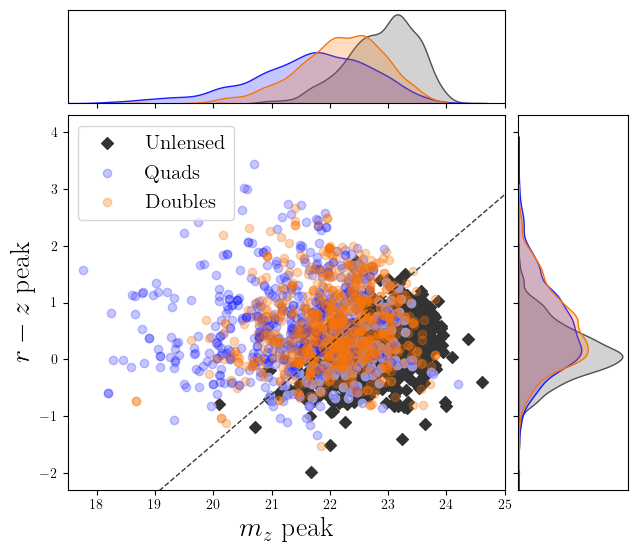

In [8]:
def colour_mag_cut(mz):
    # return mz - 22
    return 0.88 * mz - 19.1

def plot_(xx_label, yy_label, xx, yy, df, savefig=None):
    df_micro_lens_ = df_[df_.nima!=1]
    df_micro_unlen = df_[df_.nima==1]
    df_out_resolved_nim2 = df_[(df_.nima==2 ) & (df_['type']=='resolved') ]
    df_out_unresolved_nim2 = df_[(df_.nima==2 ) & (df_['type']=='unresolved') ]
    df_out_resolved_nim4   = df_[(df_.nima==4 ) & (df_['type']=='resolved') ]
    df_out_unresolved_nim4 = df_[(df_.nima==4 ) & (df_['type']=='unresolved') ]
    df_doubl = df_lens_doubl[df_detected_doubl]
    df_quads = df_lens_quads[df_detected_quads]
    
    ei = 5000
    color_gold = '#e6c700'
    N = 1800
    ri_d = np.random.randint(0, len(df_doubl), size=N)
    ri_q = np.random.randint(0, len(df_quads), size=N)
    
    x_cut = np.linspace(17, 26)
    y_cut = colour_mag_cut(x_cut) #73c7de ed1c38 doubles:00ccaa unlensed:f04158 quads:7d42b8
    # geel:fbc000 darkblue:191dff orange:f87408 green:34c52c
     
    fig = plt.figure(figsize=(7, 6))
    
    # Create the Axes.
    gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
    ax = fig.add_subplot(gs[1, 0])
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    
    ax.scatter(       df_micro_unlen[xx],        df_micro_unlen[yy]  ,alpha=1, color='#333333',marker='D', label='Unlensed')
    #plt.scatter(  df_out_resolved_nim2[xx],   df_out_resolved_nim2[yy]  ,alpha=0.2, color='blue', label='Resolved doubles')
    #plt.scatter(df_out_unresolved_nim2[xx], df_out_unresolved_nim2[yy]  ,alpha=0.2, color='blue',facecolors='none', label='Unresolved doubles')
    #plt.scatter(  df_out_resolved_nim4[xx],   df_out_resolved_nim4[yy]  ,alpha=0.2, color='green', label='Resolved quads')
    #plt.scatter(df_out_unresolved_nim4[xx], df_out_unresolved_nim4[yy]  ,alpha=0.2, color='green',facecolors='none',  label='Unresolved quads')
    ax.scatter(df_quads.iloc[ri_q][xx], df_quads.iloc[ri_q][yy]  ,alpha=0.7, color='white')
    ax.scatter(df_quads.iloc[ri_q][xx], df_quads.iloc[ri_q][yy]  ,alpha=0.25, color='#191dff',  label='Quads')
    ax.scatter(df_doubl.iloc[ri_d][xx], df_doubl.iloc[ri_d][yy]  ,alpha=0.3, color='#f87408',  label='Doubles')
    
    #ax.scatter(       df_micro_unlen[xx],        df_micro_unlen[yy]  ,alpha=1, color='None', edgecolor='#333333',marker='D')
    ax.plot(x_cut, y_cut, '--', color='#383838', lw=1)
    
    sns.kdeplot(df_micro_unlen[xx], ax=ax_histx, fill=True, color="#4f4f4f", bw_adjust=0.8)
    sns.kdeplot(np.array(df_quads.iloc[ri_q][xx]), ax=ax_histx, fill=True, color="#191dff", bw_adjust=0.8)
    sns.kdeplot(np.array(df_doubl.iloc[ri_d][xx]), ax=ax_histx, fill=True, color="#f87408", bw_adjust=0.8)
    
    sns.kdeplot(y=np.array(df_micro_unlen[yy]), ax=ax_histy, fill=True, color="#4f4f4f", bw_adjust=0.8)
    sns.kdeplot(y=np.array(df_quads.iloc[ri_q][yy]), ax=ax_histy, fill=True, color="#191dff", bw_adjust=0.8)
    sns.kdeplot(y=np.array(df_doubl.iloc[ri_d][yy]), ax=ax_histy, fill=True, color="#f87408", bw_adjust=0.8)
    ax_histx.set_ylabel(" ")
    ax_histy.set_xlabel(" ")
    ax_histx.tick_params(axis="y", labelbottom=False, left = False, right = False , labelleft = False, bottom = False)
    ax_histy.tick_params(axis="x", labelbottom=False, left = False, right = False , labelleft = False, bottom = False)
    
    ax.legend(loc='upper left', fontsize=15)
    ax.set_xlabel(xx_label, fontsize=20)
    ax.set_ylabel(yy_label, fontsize=20)
    ax.set_xlim(17.5, 25)
    ax.set_ylim(-2.3, 4.3)
    # plt.ylim(-1,3)
    # plt.savefig("../Results/Figures/Colour_magnitude_rz_02.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')
    plt.show()
    
xx_label = r'$m_z$ peak'
yy_label = r'$r-z$ peak'
xx = 'z_peak_mag_micro'
yy = 'r-z_micro'
plot_(xx_label, yy_label, xx, yy, df_[mask_microdet_], savefig='r-z_z.pdf')